In [ ]:
#ENTRY

#ENTRY

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install shap
!pip install torch==1.9.1
!pip install torchvision==0.10.1

ERROR: Could not find a version that satisfies the requirement torch==1.9.1 (from versions: 1.11.0, 1.12.0, 1.12.1, 1.13.0, 1.13.1, 2.0.0, 2.0.1, 2.1.0, 2.1.1, 2.1.2, 2.2.0, 2.2.1, 2.2.2, 2.3.0, 2.3.1, 2.4.0, 2.4.1, 2.5.0, 2.5.1)
ERROR: No matching distribution found for torch==1.9.1
ERROR: Ignored the following yanked versions: 0.1.6, 0.1.7, 0.1.8, 0.1.9, 0.2.0, 0.2.1, 0.2.2, 0.2.2.post2, 0.2.2.post3, 0.15.0
ERROR: Could not find a version that satisfies the requirement torchvision==0.10.1 (from versions: 0.12.0, 0.13.0, 0.13.1, 0.14.0, 0.14.1, 0.15.1, 0.15.2, 0.16.0, 0.16.1, 0.16.2, 0.17.0, 0.17.1, 0.17.2, 0.18.0, 0.18.1, 0.19.0, 0.19.1, 0.20.0, 0.20.1)
ERROR: No matching distribution found for torchvision==0.10.1


In [ ]:
import torch
import torchvision.transforms as transforms
from torchvision.models import inception_v3, Inception_V3_Weights
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
import PIL.Image as Image

# Configuración del dispositivo para usar CUDA si está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Definición de transformaciones para las imágenes, incluyendo la eliminación de transparencia
transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.RandomHorizontalFlip(),  # Data augmentation
    transforms.ColorJitter(),  # Data augmentation
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

from torchvision.models import inception_v3, Inception_V3_Weights

def prepare_model(num_classes, pretrained=True):
    if pretrained:
        # Specify the weights for the pretrained model
        weights = Inception_V3_Weights.IMAGENET1K_V1
    else:
        # If not using pretrained weights, set to None
        weights = None

    # Initialize the model with the specified weights
    model = inception_v3(weights=weights, aux_logits=True)

    # Replace the fully connected layer to match the number of classes in your dataset
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    model.AuxLogits.fc = nn.Linear(model.AuxLogits.fc.in_features, num_classes)

    return model.to(device)

# Preparar optimizador y función de pérdida
def prepare_optimizer_and_loss(model, learning_rate=0.001):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    loss_fn = nn.CrossEntropyLoss()
    return optimizer, loss_fn

# Scheduler para ajustar el learning rate
def prepare_scheduler(optimizer):
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    return scheduler

# Función básica de entrenamiento
def train_model(model, dataloaders, optimizer, loss_fn, scheduler, num_epochs=25):
    model.train()  # Set the model to training mode
    for epoch in range(num_epochs):
        for images, labels in dataloaders['train']:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs, aux_outputs = model(images)
            loss1 = loss_fn(outputs, labels)
            loss2 = loss_fn(aux_outputs, labels)
            loss = loss1 + 0.4 * loss2  # Combine losses

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
        scheduler.step()  # Adjust the learning rate




In [ ]:
def calculate_specificity(y_true, y_pred, labels):
    # Calculate specificity for each class
    specificity_list = []
    for label in labels:
        # All classes except the current are considered the negative class
        not_label_mask = y_true != label
        tn = np.sum((y_pred[not_label_mask] != label) & (y_true[not_label_mask] != label))
        fp = np.sum((y_pred[not_label_mask] == label) & (y_true[not_label_mask] != label))
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        specificity_list.append(specificity)
    return np.mean(specificity_list)  # Return the average specificity


In [ ]:
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np
import torch
import torchvision.transforms as transforms
from torchvision.models import inception_v3, Inception_V3_Weights
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, cohen_kappa_score, confusion_matrix


este si sirve

In [ ]:
import numpy as np
import torch
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, cohen_kappa_score, confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from scipy import interpolate
from itertools import cycle


In [ ]:
import torch
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, cohen_kappa_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize

def train_and_validate_model(model, train_loader, validation_loader, optimizer, loss_fn, epochs=25, fold_idx=1, device='cuda'):
    best_val_loss = float('inf')
    n_classes = 3
    metrics_per_fold = {
        'precision': [],
        'recall': [],
        'f1_score': [],
        'specificity': [],
        'cohen_kappa': [],
        'accuracy': [],
        'train_loss': [],
        'val_loss': [],
        'confusion_matrix': None,
        'roc_auc_micro': [],
        'roc_auc_macro': [],
        'fpr_micro': [],  # Initialize storage for micro-average FPR
        'tpr_micro': [],  # Initialize storage for micro-average TPR
        'fpr_macro': [],  # Initialize storage for macro-average FPR
        'tpr_macro': [],  # Initialize storage for macro-average TPR
        **{f'fpr_class_{i}': [] for i in range(n_classes)},
        **{f'tpr_class_{i}': [] for i in range(n_classes)},
        **{f'roc_auc_class_{i}': [] for i in range(n_classes)}
    }
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            model_output = model(images)
            outputs = model_output[0] if isinstance(model_output, tuple) else model_output
            loss = loss_fn(outputs, labels)
            if isinstance(model_output, tuple):
                aux_outputs = model_output[1]
                loss += 0.4 * loss_fn(aux_outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)
        model.eval()
        total_val_loss, all_preds, all_labels, all_probs = 0, [], [], []
        with torch.no_grad():
            for images, labels in validation_loader:
                images, labels = images.to(device), labels.to(device)
                model_output = model(images)
                outputs = model_output[0] if isinstance(model_output, tuple) else model_output
                val_loss = loss_fn(outputs, labels)
                if isinstance(model_output, tuple):
                    aux_outputs = model_output[1]
                    val_loss += 0.4 * loss_fn(aux_outputs, labels)
                total_val_loss += val_loss.item()
                preds = outputs.argmax(dim=1)
                all_probs.extend(torch.softmax(outputs, dim=1).cpu().numpy())
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        avg_val_loss = total_val_loss / len(validation_loader)
        all_preds = np.array(all_preds)
        all_labels = np.array(all_labels)
        all_probs = np.array(all_probs)

        precision = precision_score(all_labels, all_preds, average='macro')
        recall = recall_score(all_labels, all_preds, average='macro')
        f1 = f1_score(all_labels, all_preds, average='macro')
        accuracy = accuracy_score(all_labels, all_preds)
        kappa = cohen_kappa_score(all_labels, all_preds)
        specificity = calculate_specificity(all_labels, all_preds, np.unique(all_labels))
        cm = confusion_matrix(all_labels, all_preds)

        # Binarize the labels for ROC calculation
        all_labels_bin = label_binarize(all_labels, classes=np.unique(all_labels))
        if all_labels_bin.shape[1] == 1:
            all_labels_bin = np.append(1 - all_labels_bin, all_labels_bin, axis=1)

        # ROC curve calculations...
        fpr, tpr, roc_auc = {}, {}, {}
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(all_labels_bin[:, i], all_probs[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        # Compute micro-average ROC curve and ROC area
        fpr["micro"], tpr["micro"], _ = roc_curve(all_labels_bin.ravel(), all_probs.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

        # Compute macro-average ROC curve and ROC area
        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(n_classes):
            mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
        mean_tpr /= n_classes
        fpr["macro"], tpr["macro"], roc_auc["macro"] = all_fpr, mean_tpr, auc(all_fpr, mean_tpr)

        # Update metrics_per_fold with epoch metrics
        metrics_per_fold['precision'].append(precision)
        metrics_per_fold['recall'].append(recall)
        metrics_per_fold['f1_score'].append(f1)
        metrics_per_fold['specificity'].append(specificity)
        metrics_per_fold['cohen_kappa'].append(kappa)
        metrics_per_fold['accuracy'].append(accuracy)
        metrics_per_fold['train_loss'].append(avg_train_loss)
        metrics_per_fold['val_loss'].append(avg_val_loss)
        metrics_per_fold['confusion_matrix'] = cm
        metrics_per_fold['roc_auc_micro'].append(roc_auc["micro"])
        metrics_per_fold['roc_auc_macro'].append(roc_auc["macro"])

        # Save FPR and TPR for micro and macro averages
        metrics_per_fold['fpr_micro'].append(fpr["micro"])
        metrics_per_fold['tpr_micro'].append(tpr["micro"])
        metrics_per_fold['fpr_macro'].append(fpr["macro"])
        metrics_per_fold['tpr_macro'].append(tpr["macro"])

        # Update class-specific ROC metrics
        for i in range(n_classes):
            metrics_per_fold[f'fpr_class_{i}'].append(fpr[i])
            metrics_per_fold[f'tpr_class_{i}'].append(tpr[i])
            metrics_per_fold[f'roc_auc_class_{i}'].append(roc_auc[i])

        print(f'Fold {fold_idx}, Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, '
              f'Val Loss: {avg_val_loss:.4f}, Precision: {precision:.4f}, '
              f'Recall: {recall:.4f}, F1: {f1:.4f}, Specificity: {specificity:.4f}, '
              f'Kappa: {kappa:.4f}, Accuracy: {accuracy:.4f}, '
              f'Micro AUC: {roc_auc["micro"]:.4f}, Macro AUC: {roc_auc["macro"]:.4f}')
        print(f'Confusion Matrix:\n{cm}')

        if best_val_loss > avg_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), f'best_model_fold_{fold_idx}.pth')

    return metrics_per_fold


In [ ]:
# Function to create dataloaders for k-fold cross-validation
def load_data_for_cross_validation(directory, k_folds=5, batch_size=32):
    # Load the entire dataset
    dataset = ImageFolder(root=directory, transform=transform)

    # Creating indices for the entire dataset and splitting them into k folds
    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    np.random.shuffle(indices)
    split = int(np.floor(dataset_size/k_folds))

    # Dataloaders for each fold
    dataloaders = []

    for fold in range(k_folds):
        train_indices = indices[:fold * split] + indices[(fold + 1) * split:]
        val_indices = indices[fold * split:(fold + 1) * split]

        # Creating PT data samplers and loaders:
        train_sampler = SubsetRandomSampler(train_indices)
        valid_sampler = SubsetRandomSampler(val_indices)

        train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
        validation_loader = DataLoader(dataset, batch_size=batch_size, sampler=valid_sampler)

        dataloaders.append((train_loader, validation_loader))

    return dataloaders


In [ ]:
import numpy as np

def safe_mean(arrays):
    """Attempt to calculate the mean of arrays, even if they are of different lengths."""
    try:
        return np.mean(arrays)
    except ValueError:
        # Handle arrays of different shapes by returning None or some other placeholder value
        return None

def mean_of_metrics(all_fold_metrics):
    mean_metrics = {}
    for metric in all_fold_metrics[0].keys():
        metric_values = [fold_metrics[metric] for fold_metrics in all_fold_metrics]

        if isinstance(metric_values[0], (int, float, np.number)):
            mean_metrics[metric] = np.mean(metric_values)
        elif isinstance(metric_values[0], list):
            mean_metrics[metric] = [safe_mean([metric_values[fold][epoch] if epoch < len(metric_values[fold]) else np.nan
                                               for fold in range(len(all_fold_metrics))])
                                    for epoch in range(max(len(l) for l in metric_values))]
        elif isinstance(metric_values[0], dict):
            mean_dict = {}
            for key in metric_values[0].keys():
                # Collect all lists for this key across folds, handling variable lengths
                lists_for_key = [fold_metrics[key] for fold_metrics in metric_values if key in fold_metrics]
                max_length = max(len(l) for l in lists_for_key) if lists_for_key else 0
                mean_dict[key] = [safe_mean([l[epoch] if epoch < len(l) else np.nan for l in lists_for_key])
                                  for epoch in range(max_length)]
            mean_metrics[metric] = mean_dict
        else:
            print(f"Metric '{metric}' has an unsupported type and will be skipped.")

    return mean_metrics


modify for kfolds and epochs

In [ ]:
# Set up the directory and parameters
directory = '/content/drive/MyDrive/papertaro/Hojascompleto'
k_folds = 5
batch_size = 32
num_classes = 3  # Number of classes in the dataset
num_epochs = 20  # Number of epochs to train for each fold

# Load the data for cross-validation
dataloaders = load_data_for_cross_validation(directory, k_folds=k_folds, batch_size=batch_size)


In [16]:

# Variable to store metrics for each fold
all_fold_metrics = []

# Perform k-fold cross-validation
for fold_index, (train_loader, validation_loader) in enumerate(dataloaders, 1):
    print(f'Starting Fold {fold_index}')

    # Re-initialize the model for each fold
    model = prepare_model(num_classes, pretrained=True).to(device)
    optimizer, loss_fn = prepare_optimizer_and_loss(model)

    # Train and validate the model for the current fold
    fold_metrics = train_and_validate_model(
        model,
        train_loader,
        validation_loader,
        optimizer,
        loss_fn,
        epochs=num_epochs,
        fold_idx=fold_index
    )

    # Store the metrics
    all_fold_metrics.append(fold_metrics)

# Example usage:
mean_metrics = mean_of_metrics(all_fold_metrics)
print(f'Average metrics across all folds: {mean_metrics}')


Starting Fold 1
Fold 1, Epoch [1/20], Train Loss: 0.2354, Val Loss: 0.0359, Precision: 0.9900, Recall: 0.9915, F1: 0.9907, Specificity: 0.9967, Kappa: 0.9886, Accuracy: 0.9927, Micro AUC: 0.9997, Macro AUC: 0.9998
Confusion Matrix:
[[ 85   1   0]
 [  2 141   0]
 [  0   0 183]]
Fold 1, Epoch [2/20], Train Loss: 0.1567, Val Loss: 0.0491, Precision: 0.9909, Recall: 0.9907, F1: 0.9907, Specificity: 0.9950, Kappa: 0.9848, Accuracy: 0.9903, Micro AUC: 0.9984, Macro AUC: 0.9991
Confusion Matrix:
[[ 85   1   0]
 [  0 143   0]
 [  0   3 180]]
Fold 1, Epoch [3/20], Train Loss: 0.0430, Val Loss: 0.0017, Precision: 1.0000, Recall: 1.0000, F1: 1.0000, Specificity: 1.0000, Kappa: 1.0000, Accuracy: 1.0000, Micro AUC: 1.0000, Macro AUC: 1.0000
Confusion Matrix:
[[ 86   0   0]
 [  0 143   0]
 [  0   0 183]]
Fold 1, Epoch [4/20], Train Loss: 0.0178, Val Loss: 0.0009, Precision: 1.0000, Recall: 1.0000, F1: 1.0000, Specificity: 1.0000, Kappa: 1.0000, Accuracy: 1.0000, Micro AUC: 1.0000, Macro AUC: 1.0000


In [17]:
# Initialize a list to hold the last epoch metrics for each fold
last_epoch_metrics_for_each_fold = []

# Loop through each fold's metrics
for fold_metrics in all_fold_metrics:
    # Extract the last epoch metrics for the current fold
    last_epoch_metrics = {metric_name: metric_values[-1] for metric_name, metric_values in fold_metrics.items()}
    # Add the extracted metrics to the list
    last_epoch_metrics_for_each_fold.append(last_epoch_metrics)

# Now, last_epoch_metrics_for_each_fold contains the last epoch metrics for each fold
# If you need to print or further process these, you can iterate over the list
for i, metrics in enumerate(last_epoch_metrics_for_each_fold, start=1):
    print(f"Fold {i} last epoch metrics: {metrics}")


Fold 1 last epoch metrics: {'precision': 0.8207885304659498, 'recall': 0.7806565019679774, 'f1_score': 0.73666130626084, 'specificity': 0.8977505112474438, 'cohen_kappa': 0.6423300633735567, 'accuracy': 0.7572815533980582, 'train_loss': 0.02528505622663383, 'val_loss': 1.714240509730119, 'confusion_matrix': array([ 27,   0, 156]), 'roc_auc_micro': 0.8887530634367047, 'roc_auc_macro': 0.9477487190040297, 'fpr_micro': array([0.        , 0.00364078, 0.00485437, 0.00728155, 0.00970874,
       0.01092233, 0.01092233, 0.01334951, 0.01456311, 0.01820388,
       0.01820388, 0.01941748, 0.01941748, 0.02063107, 0.02063107,
       0.02063107, 0.02063107, 0.02063107, 0.02305825, 0.02427184,
       0.02427184, 0.02427184, 0.02548544, 0.02548544, 0.02548544,
       0.02548544, 0.02548544, 0.02669903, 0.02791262, 0.02912621,
       0.02912621, 0.02912621, 0.02912621, 0.03033981, 0.03033981,
       0.0315534 , 0.0315534 , 0.0315534 , 0.0315534 , 0.0315534 ,
       0.0315534 , 0.0315534 , 0.0315534 , 0

In [18]:
# Assuming all_fold_metrics is a list of dictionaries, with each dictionary containing metrics for a fold
interested_metrics = ['precision', 'recall', 'f1_score', 'specificity', 'cohen_kappa', 'accuracy', 'roc_auc_micro', 'roc_auc_macro']

# Process each fold's metrics
for fold_index, fold_metrics in enumerate(all_fold_metrics, start=1):
    # Extract the last epoch's values for the interested metrics for the current fold
    last_epoch_values = {metric: fold_metrics[metric][-1] for metric in interested_metrics}

    # Display the fold number and the extracted values
    print(f"Fold {fold_index} last epoch metrics:")
    for metric, value in last_epoch_values.items():
        print(f"  {metric.capitalize()}: {value:.4f}")
    print()  # Add a blank line for better separation between folds


Fold 1 last epoch metrics:
  Precision: 0.8208
  Recall: 0.7807
  F1_score: 0.7367
  Specificity: 0.8978
  Cohen_kappa: 0.6423
  Accuracy: 0.7573
  Roc_auc_micro: 0.8888
  Roc_auc_macro: 0.9477

Fold 2 last epoch metrics:
  Precision: 0.9826
  Recall: 0.9885
  F1_score: 0.9852
  Specificity: 0.9948
  Cohen_kappa: 0.9812
  Accuracy: 0.9879
  Roc_auc_micro: 0.9986
  Roc_auc_macro: 0.9988

Fold 3 last epoch metrics:
  Precision: 0.9979
  Recall: 0.9963
  F1_score: 0.9971
  Specificity: 0.9987
  Cohen_kappa: 0.9962
  Accuracy: 0.9976
  Roc_auc_micro: 1.0000
  Roc_auc_macro: 1.0000

Fold 4 last epoch metrics:
  Precision: 0.9725
  Recall: 0.9867
  F1_score: 0.9789
  Specificity: 0.9930
  Cohen_kappa: 0.9734
  Accuracy: 0.9830
  Roc_auc_micro: 0.9996
  Roc_auc_macro: 1.0000

Fold 5 last epoch metrics:
  Precision: 1.0000
  Recall: 1.0000
  F1_score: 1.0000
  Specificity: 1.0000
  Cohen_kappa: 1.0000
  Accuracy: 1.0000
  Roc_auc_micro: 1.0000
  Roc_auc_macro: 1.0000



#figuras

##validation and loss

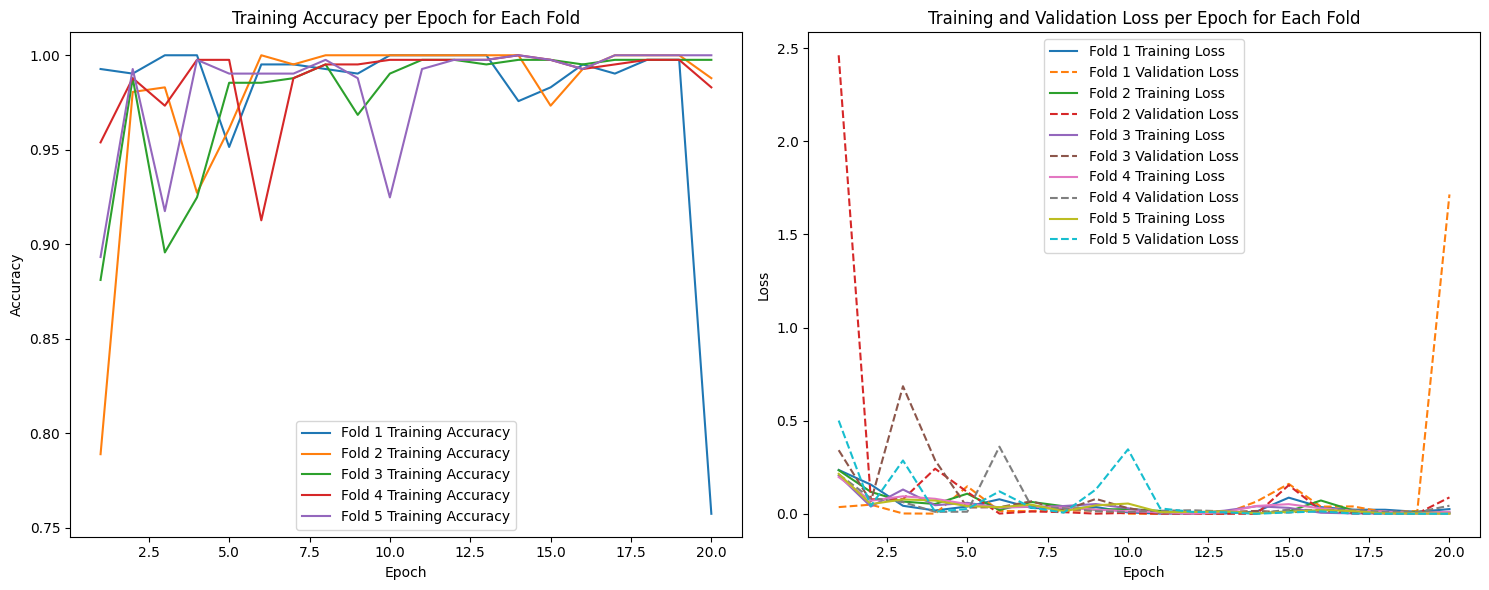

In [19]:
import matplotlib.pyplot as plt

# Assuming num_epochs is defined as 3 from your code snippet
epochs = range(1, num_epochs + 1)

# Create subplots: one for accuracy and one for loss
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Loop over the all_fold_metrics list and plot accuracy and loss per fold
for i, fold_metrics in enumerate(all_fold_metrics):
    fold_idx = i + 1  # since enumeration in your loop starts from 1

    # Plot accuracy for this fold
    ax1.plot(epochs, fold_metrics['accuracy'], label=f'Fold {fold_idx} Training Accuracy')

    # Plot training and validation loss for this fold
    ax2.plot(epochs, fold_metrics['train_loss'], label=f'Fold {fold_idx} Training Loss')
    ax2.plot(epochs, fold_metrics['val_loss'], label=f'Fold {fold_idx} Validation Loss', linestyle='--')

# Set titles and labels for the accuracy plot
ax1.set_title('Training Accuracy per Epoch for Each Fold')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()

# Set titles and labels for the loss plot
ax2.set_title('Training and Validation Loss per Epoch for Each Fold')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

# Show plot with tight layout
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/papertaro/Resultados/InceptionV3/lossIV3_kfold_epochs_2.png", dpi = 600)
plt.show()


##CM

In [ ]:
import os
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

def plot_and_save_confusion_matrix(cm, fold_idx, save_path="confusion_matrices"):
    """
    Plots and saves the confusion matrix for a given fold.

    Parameters:
    - cm: The confusion matrix to plot.
    - fold_idx: The index of the current fold (for title and filename).
    - save_path: Base directory to save the plots.
    """
    fig, ax = plt.subplots(figsize=(5, 5))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='viridis', ax=ax)
    ax.set_title(f'Confusion Matrix for Fold {fold_idx}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

    # Ensure the save directory exists
    os.makedirs(save_path, exist_ok=True)
    plt.savefig("/content/drive/MyDrive/papertaro/confusion_matrix.png")
    plt.show()

# Iterate over all_fold_metrics to plot and save each fold's confusion matrix
for idx, fold_metrics in enumerate(all_fold_metrics, start=1):
    cm = fold_metrics['confusion_matrix']
    plot_and_save_confusion_matrix(cm, idx)


In [ ]:
import os
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

def plot_and_save_confusion_matrix(cm, fold_idx, save_path):
    """
    Plots and saves the confusion matrix for a given fold.

    Parameters:
    - cm: The confusion matrix to plot.
    - fold_idx: The index of the current fold (for title and filename).
    - save_path: Base directory to save the plots.
    """
    fig, ax = plt.subplots(figsize=(5, 5))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='viridis', ax=ax)
    ax.set_title(f'Confusion Matrix for Fold {fold_idx}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

    # Ensure the save directory exists
    os.makedirs(save_path, exist_ok=True)
    # Save each plot with a unique name using fold_idx
    filename = os.path.join(save_path, f'confusion_matrix_fold_{fold_idx}.png')
    plt.savefig(filename)
    plt.close(fig)  # Close the figure to free memory

# Base save path defined here
base_save_path = "/content/drive/MyDrive/papertaro/Resultados/InceptionV3/"

# Assume all_fold_metrics is defined somewhere in your code
# Iterate over all_fold_metrics to plot and save each fold's confusion matrix
for idx, fold_metrics in enumerate(all_fold_metrics, start=1):
    cm = fold_metrics['confusion_matrix']
    plot_and_save_confusion_matrix(cm, idx, base_save_path)


##ROCS

In [ ]:
def plot_roc_curves_for_all_folds_last_epoch(all_fold_metrics, num_classes):
    n_folds = len(all_fold_metrics)
    plt.figure(figsize=(14, n_folds * 4))

    for fold_idx, metrics in enumerate(all_fold_metrics, 1):
        # Setup subplot for each fold
        ax = plt.subplot(n_folds, 1, fold_idx)

        # Plot micro-average ROC curve
        fpr_micro = metrics['fpr_micro'][-1]
        tpr_micro = metrics['tpr_micro'][-1]
        roc_auc_micro = metrics['roc_auc_micro'][-1]
        ax.plot(fpr_micro, tpr_micro, label=f'Micro-average ROC curve (area = {roc_auc_micro:.2f})', color='deeppink', linestyle=':', linewidth=4)

        # Plot macro-average ROC curve
        fpr_macro = metrics['fpr_macro'][-1]
        tpr_macro = metrics['tpr_macro'][-1]
        roc_auc_macro = metrics['roc_auc_macro'][-1]
        ax.plot(fpr_macro, tpr_macro, label=f'Macro-average ROC curve (area = {roc_auc_macro:.2f})', color='navy', linestyle=':', linewidth=4)

        # Plot ROC curve for each class
        for i in range(num_classes):
            fpr_class = metrics[f'fpr_class_{i}'][-1]
            tpr_class = metrics[f'tpr_class_{i}'][-1]
            roc_auc_class = metrics[f'roc_auc_class_{i}'][-1]
            ax.plot(fpr_class, tpr_class, lw=2, label=f'Class {i} ROC curve (area = {roc_auc_class:.2f})')

        ax.plot([0, 1], [0, 1], 'k--', lw=2)
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title(f'ROC Curves for Fold {fold_idx}')
        ax.legend(loc="lower right")

    plt.tight_layout()
    plt.show()


In [ ]:
# Call the updated function with your all_fold_metrics and the number of classes
plot_roc_curves_for_all_folds_last_epoch(all_fold_metrics, num_classes=3)


In [ ]:
import matplotlib.pyplot as plt

def plot_roc_curves_for_all_folds_last_epoch(all_fold_metrics, num_classes, save_path=None):
    n_folds = len(all_fold_metrics)
    plt.figure(figsize=(8, n_folds * 4))

    for fold_idx, metrics in enumerate(all_fold_metrics, 1):
        # Setup subplot for each fold
        ax = plt.subplot(n_folds, 1, fold_idx)

        # Plot micro-average ROC curve
        fpr_micro = metrics['fpr_micro'][-1]
        tpr_micro = metrics['tpr_micro'][-1]
        roc_auc_micro = metrics['roc_auc_micro'][-1]
        ax.plot(fpr_micro, tpr_micro, label=f'Micro-average ROC curve (area = {roc_auc_micro:.2f})', color='deeppink', linestyle=':', linewidth=4)

        # Plot macro-average ROC curve
        fpr_macro = metrics['fpr_macro'][-1]
        tpr_macro = metrics['tpr_macro'][-1]
        roc_auc_macro = metrics['roc_auc_macro'][-1]
        ax.plot(fpr_macro, tpr_macro, label=f'Macro-average ROC curve (area = {roc_auc_macro:.2f})', color='navy', linestyle=':', linewidth=4)

        # Plot ROC curve for each class
        for i in range(num_classes):
            fpr_class = metrics[f'fpr_class_{i}'][-1]
            tpr_class = metrics[f'tpr_class_{i}'][-1]
            roc_auc_class = metrics[f'roc_auc_class_{i}'][-1]
            ax.plot(fpr_class, tpr_class, lw=2, label=f'Class {i} ROC curve (area = {roc_auc_class:.2f})')

        ax.plot([0, 1], [0, 1], 'k--', lw=2)
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title(f'ROC Curves for Fold {fold_idx}')
        ax.legend(loc="lower right")

    plt.tight_layout()

    # Check if a save path is provided
    if save_path:
        plt.savefig(save_path, dpi=300)  # Save the figure to the specified path with 300 dpi resolution
        print(f"Plot saved to {save_path}")
    else:
        plt.show()  # Show the plot as before if no save path is provided


In [ ]:
save_path = '/content/drive/MyDrive/papertaro/Resultados/InceptionV3/roc_curves.png'


In [ ]:
plot_roc_curves_for_all_folds_last_epoch(all_fold_metrics, num_classes, save_path=save_path)


#SHAPS

In [ ]:
!pip install shap

import the best model from the k-folds

In [ ]:
import shap
# Initialize the model architecture as per the last training configuration
num_classes = 3  # Replace with the actual number of classes you have
model = prepare_model(num_classes, pretrained=True)

# Load the trained model weights
model.load_state_dict(torch.load('best_model_fold_2.pth', map_location=device))
model.eval()  # Set the model to evaluation mode




In [ ]:

# Initialize the model architecture as per the last training configuration
num_classes = 3  # Replace with the actual number of classes you have
model = prepare_model(num_classes, pretrained=True)

# Load the trained model weights
model.load_state_dict(torch.load('best_model_fold_2.pth', map_location=device))
model.eval()  # Set the model to evaluation mode


import shap

# Free up memory if possible
torch.cuda.empty_cache()

# Select a representative background sample instead of the full dataset
background_loader = DataLoader(ImageFolder(root=directory, transform=transform), batch_size=100, shuffle=True)  # smaller batch size
background_data, _ = next(iter(background_loader))
background_data = background_data.to(device)

# Initialize SHAP using the smaller background sample
e = shap.GradientExplainer(model, background_data)

# Get a batch of test data
test_loader = DataLoader(ImageFolder(root=directory, transform=transform), batch_size=1, shuffle=True)  # single image batch
test_images, _ = next(iter(test_loader))
test_images = test_images.to(device)

# Compute SHAP values for a single test image
shap_values = e.shap_values(test_images)

# Assuming `test_images` is a tensor of shape (N, C, H, W)

# Convert to numpy and adjust the dimensions to (N, H, W, C) for plotting
test_images_np = test_images.cpu().numpy().transpose(0, 2, 3, 1)

# Optionally, reverse the normalization
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

# Apply the reverse normalization formula
test_images_np = std * test_images_np + mean
test_images_np = np.clip(test_images_np, 0, 1)  # Ensure the values are in the range [0,1]

# Compute predictions for the test images
output = model(test_images)

# Assuming output is the model prediction and shap_values has been computed
predicted_class = output.argmax(1).item()

# The SHAP values for the predicted class should be selected as follows
shap_values_for_class = shap_values[0][predicted_class]

# Confirm the shape of the SHAP values for the class
print('Shape of SHAP values for class:', shap_values_for_class.shape)

# Assuming test_images_np contains the denormalized images correctly shaped for plotting
test_image_for_plotting = test_images_np[0]

# Now let's plot the SHAP values with the denormalized image
shap.image_plot(shap_values_for_class, test_image_for_plotting)


In [ ]:
save_dir = '/content/'  # Adjust the path as needed

In [ ]:
import os

if not os.path.exists(save_dir):
    os.makedirs(save_dir)


In [ ]:
import shap
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import numpy as np

# Free up memory if possible
torch.cuda.empty_cache()

# Parameters
num_classes = 3  # Adjust based on your model
num_images_per_class = 10  # Number of images you want to process for each class

# Select a representative background sample instead of the full dataset
background_loader = DataLoader(ImageFolder(root=directory, transform=transform), batch_size=100, shuffle=True)  # smaller batch size
background_data, _ = next(iter(background_loader))
background_data = background_data.to(device)

# Initialize SHAP using the smaller background sample
e = shap.GradientExplainer(model, background_data)

# Load all test data
test_loader = DataLoader(ImageFolder(root=directory, transform=transform), batch_size=1, shuffle=True)

images_per_class = {class_idx: [] for class_idx in range(num_classes)}  # Store test images by predicted class
shap_values_per_class = {class_idx: [] for class_idx in range(num_classes)}  # Store SHAP values by predicted class

for test_images, _ in test_loader:
    if all(len(images) >= num_images_per_class for images in images_per_class.values()):
        break  # Stop once we have enough images for each class

    test_images = test_images.to(device)

    # Compute predictions to determine the class
    output = model(test_images)
    predicted_class = output.argmax(1).item()

    if len(images_per_class[predicted_class]) < num_images_per_class:
        # Compute SHAP values for the predicted class
        shap_values = e.shap_values(test_images)
        shap_values_for_class = shap_values[0][predicted_class]

        # Store image and its SHAP values
        images_per_class[predicted_class].append(test_images)
        shap_values_per_class[predicted_class].append(shap_values_for_class)

# Optionally, reverse the normalization for plotting
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

for class_idx in range(num_classes):
    for image_idx in range(num_images_per_class):
        test_image = images_per_class[class_idx][image_idx].cpu().numpy().transpose(0, 2, 3, 1)
        test_image = std * test_image + mean  # Reverse normalization
        test_image = np.clip(test_image, 0, 1)  # Ensure the values are in the range [0,1]

        shap_values_for_plotting = shap_values_per_class[class_idx][image_idx]

        # Plot the SHAP values with the denormalized image
        print(f"Class {class_idx}, Image {image_idx+1}:")
        shap.image_plot(shap_values_for_plotting, test_image[0])  # Adjust if necessary for correct plotting


##PARA GUARDAR LAS IMAGENES DE LOS SHAPS

In [ ]:
import matplotlib
matplotlib.use('Agg')  # Use the 'Agg' backend for saving figures
import matplotlib.pyplot as plt

for class_idx in range(num_classes):
    for image_idx in range(num_images_per_class):
        test_image = images_per_class[class_idx][image_idx].cpu().numpy().transpose(0, 2, 3, 1)
        test_image = std * test_image + mean  # Reverse normalization
        test_image = np.clip(test_image, 0, 1)  # Ensure the values are in the range [0,1]

        shap_values_for_plotting = shap_values_per_class[class_idx][image_idx]

         # Create a figure for plotting
        plt.figure(figsize=(20, 10))
        shap.image_plot(shap_values_for_plotting, test_image[0])

        # Define the save path for each image
        image_save_path = os.path.join(save_dir, f'class_{class_idx}_image_{image_idx+1}.png')

        # Save the figure with high resolution
        plt.savefig(image_save_path, dpi=300, bbox_inches='tight', pad_inches=0)
        plt.close()

#intento shaps